<a href="https://colab.research.google.com/github/FredArgoX/ChaoticTest_Keras/blob/main/Ex_01_Image_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source:
[Image classification from scratch
](https://keras.io/examples/vision/image_classification_from_scratch/)

# Image classification from scratch

Description: Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

# Introduction

This example shows how to do image classification fro scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.

We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standarization and data augmentation.

# Setup

In [2]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

# Load the data: the Cats vs Dogs dataset

### Raw data download
First, let's download the 786M ZIP archive of the raw data

In [3]:
! curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  95.6M      0  0:00:08  0:00:08 --:--:-- 52.6M


In [4]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


Now we have a PetImages folder which contain two subfolders, Cat and Dog. Each subfolder contains image files for each category

In [5]:
!ls PetImages

Cat  Dog


### Filter out corrupted images
When working with lots of real-world image data, corrupted images are a common occurrence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [6]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
  folder_path = os.path.join("PetImages", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = b"JFIF" in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1
      # Delete corrupted image
      os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


# Generate a dataset

In [7]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


# Visualize the data

Here are the first 9 images in the training dataset

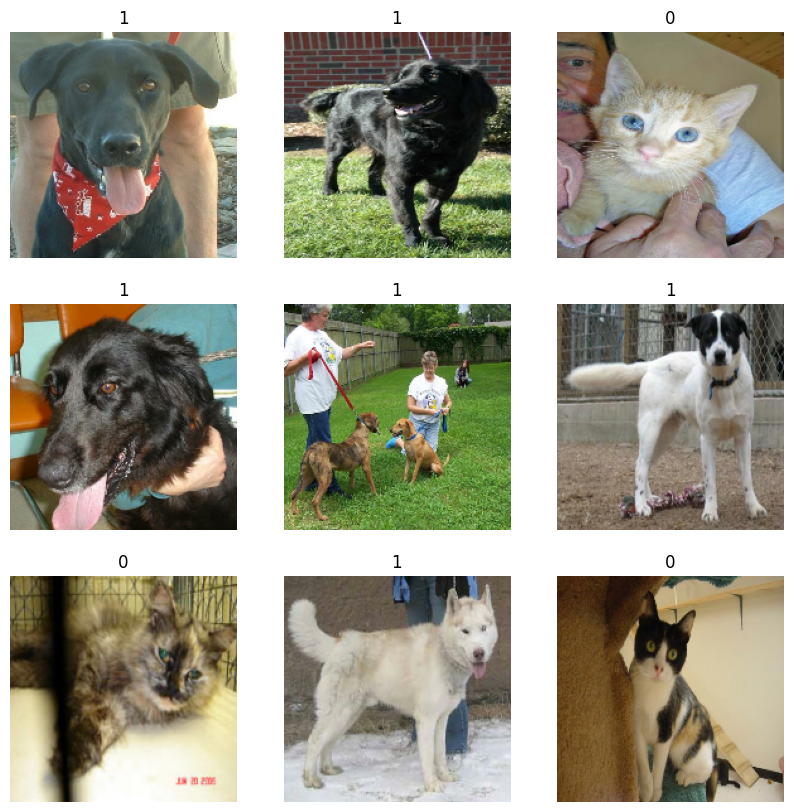

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis('off')

# Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [9]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first few images in the dataset

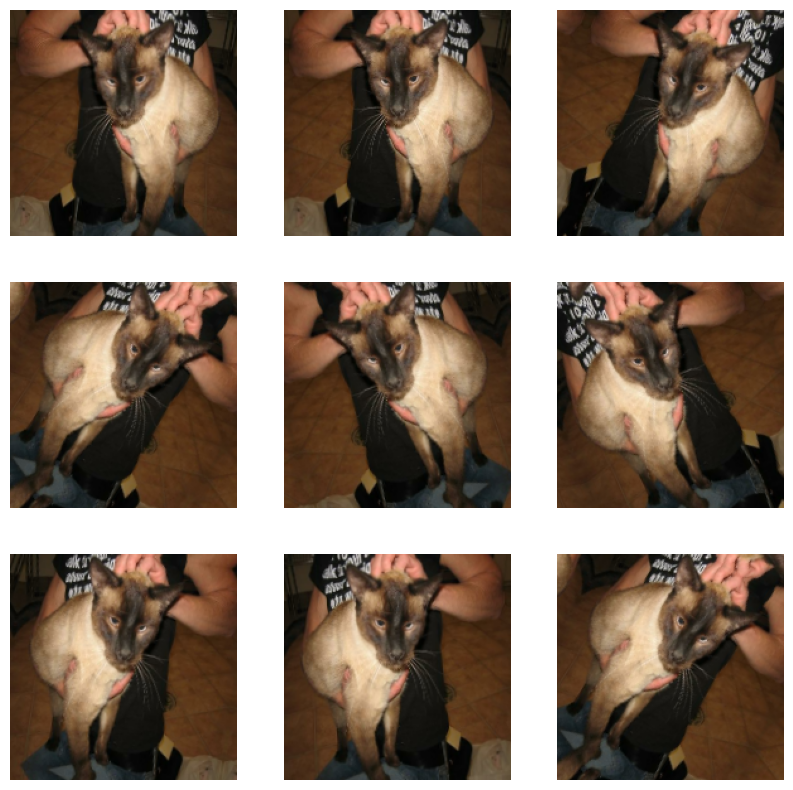

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(np.array(augmented_images[0]).astype("uint8"))
    plt.axis("off")

# Standarizing the data

Our images are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standarize values to be in the [0, 1] by using Rescaling layer at the start of our model.

There are two ways you could be using the data_augmentation preprocessor:

Option 1: Make it part of the model.

In [10]:
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
# ... Rest of the model

With this option, your data augmentation will happend on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be augmented during fit(), not when calling evaluate() or predict().

If you're training on GPU, this may be a good option.

Option 2: Apply it to the dataset, so as to obtain a dataset that yields batches of augmented images, like this:

In [12]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

# Configure the dataset for performance

Let's apply data augmentation to our dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [13]:
# Apply 'data_augmentation' to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls = tf_data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

# Build a model

# Train the model

# Run inference on new data